## Explore simple RNN with keras

### Introduction
This notebook will build a simple RNN model using keras to solve classification sentiment problem for movie reviews.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

### Import libraries,  import custom scripts and define constants  

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SpatialDropout1D, LSTM, Dropout, SpatialDropout2D, SpatialDropout3D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

import re

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# import all our functions
import os,sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/ml_training/app_predict/')
from src import preprocessing

In [ ]:
#definition constants
RANDOM_STATE = 11
TEST_SIZE = 0.15


####  Loading the data and applying the preprocessing

In [6]:
# import & display data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ml_training/data/IMDB_Dataset.csv')
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})
data = data.drop_duplicates()
data['review'] = data['review'].apply(lambda x: preprocessing.preprocessing_text(x))
data.head()


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming t...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


#### Explore the parameters of reviews (their length)

In [7]:
print('Average word length of reviews in dataset is {0:.0f}.'.format(np.mean(data['review'].apply(lambda x: len(x.split())))))

Average word length of reviews in dataset is 230.


In [8]:
print('Max word length  of reviews in dataset is {0:.0f}.'.format(np.max(data['review'].apply(lambda x: len(x.split())))))

Max word length  of reviews in dataset is 2479.


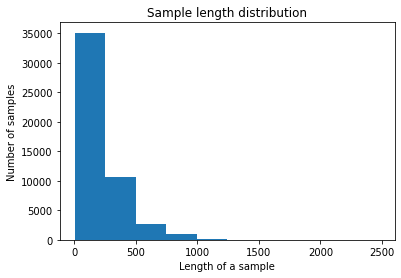

In [9]:
plt.hist([len(s.split()) for s in data['review']], 10)
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

We can see that most of the reviews are 500 words long or shorter. Let's try having sequence length equal to 500 for now.

####  Split data for training, testing and validation sets

In [ ]:
X = data.review
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                    y_train,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y_train)

### Preprocessing Data

In [ ]:
MAX_FEATURES = 50000
MAX_LEN = 500


tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='unk')

# only fit on train
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

### Create and train the model 

In [ ]:
#function for f1 metric
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
# Stricture0

EMBED_DIM = 300
LSTM_OUT = 128

#callbacks
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5)
cp_callback = ModelCheckpoint(filepath="model_lstm_0_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBED_DIM))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [get_f1])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________


In [17]:
batch_size = 512
epochs = 30

history = model.fit(X_train_pad, y_train,
                    batch_size=batch_size,                  
                    epochs=epochs,                   
                    verbose=2,                   
                    callbacks=[early_stop, cp_callback],                    
                    validation_data=(X_val_pad, y_val),                     
                    shuffle=True)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.28140, saving model to model_lstm_0_01-0.89.hdf5
70/70 - 584s - loss: 0.4702 - get_f1: 0.7546 - val_loss: 0.2814 - val_get_f1: 0.8904
Epoch 2/30

Epoch 00002: val_loss improved from 0.28140 to 0.26539, saving model to model_lstm_0_02-0.90.hdf5
70/70 - 581s - loss: 0.2025 - get_f1: 0.9260 - val_loss: 0.2654 - val_get_f1: 0.8959
Epoch 3/30

Epoch 00003: val_loss did not improve from 0.26539
70/70 - 581s - loss: 0.1178 - get_f1: 0.9603 - val_loss: 0.2955 - val_get_f1: 0.8895
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.26539
70/70 - 577s - loss: 0.0634 - get_f1: 0.9808 - val_loss: 0.3638 - val_get_f1: 0.8765
Epoch 5/30

Epoch 00005: val_loss did not improve from 0.26539
70/70 - 581s - loss: 0.0541 - get_f1: 0.9828 - val_loss: 0.4242 - val_get_f1: 0.8695
Epoch 6/30

Epoch 00006: val_loss did not improve from 0.26539
70/70 - 577s - loss: 0.0550 - get_f1: 0.9815 - val_loss: 0.4522 - val_get_f1: 0.8360
Epoch 7/30

Epoch 0000

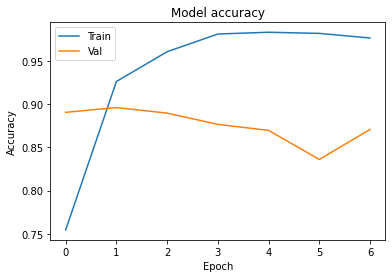

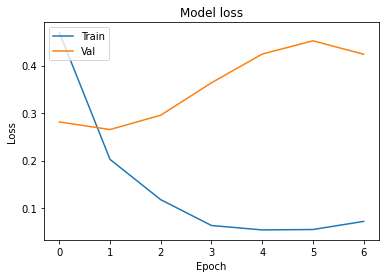

In [18]:
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Structure1:
    
EMBED_DIM = 300
LSTM_OUT = 128

log_dir = "logs/lstm/Structure1"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure1_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model1 = Sequential()
model1.add(Embedding(MAX_FEATURES, EMBED_DIM))
model1.add(SpatialDropout1D(0.4))
model1.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model1.summary()



batch_size = 512
epochs = 30

history1 = model1.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.33028, saving model to Structure1_01-0.87.hdf5
35822/35822 - 88s - loss: 0.5146 - accuracy: 0.7473 - get_f1: 0.7517 - val_loss: 0.3303 -

In [ ]:
# Structure2:
    
EMBED_DIM = 300
LSTM_OUT = 128

log_dir = "logs/lstm/Structure2"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure2_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model2 = Sequential()
model2.add(Embedding(MAX_FEATURES, EMBED_DIM))
model2.add(Dropout(0.4))
model2.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model2.summary()

batch_size = 512
epochs = 30

history2 = model2.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.33505, saving model to Structure2_01-0.87.hdf5
35822/35822 - 91s - loss: 0.5095 - accuracy: 0.7437 - get_f1: 0.6997 - val_loss: 0.3350 -

In [ ]:
# Structure3:

MAX_FEATURES_3 = 20000
MAX_LEN_3 = 200


tokenizer_3 = Tokenizer(num_words=MAX_FEATURES_3, oov_token='unk')

# only fit on train
tokenizer_3.fit_on_texts(X_train)

X_train_seq_3 = tokenizer_3.texts_to_sequences(X_train)
X_val_seq_3 = tokenizer_3.texts_to_sequences(X_val)
X_test_seq_3 = tokenizer_3.texts_to_sequences(X_test)


X_train_pad_3 = pad_sequences(X_train_seq_3, maxlen=MAX_LEN_3)
X_val_pad_3 = pad_sequences(X_val_seq_3, maxlen=MAX_LEN_3)
X_test_pad_3 = pad_sequences(X_test_seq_3, maxlen=MAX_LEN_3)

EMBED_DIM_3 = 128
LSTM_OUT = 128

log_dir = "logs/lstm/Structure3"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure3_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model3 = Sequential()
model3.add(Embedding(MAX_FEATURES_3, EMBED_DIM_3))
model3.add(Dropout(0.4))
model3.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model3.summary()

batch_size = 512
epochs = 30

history3 = model3.fit(X_train_pad_3, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad_3, y_val), 
                    shuffle=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.33252, saving model to Structure3_01-0.86.hdf5
35822/35822 - 30s - loss: 0.5819 - accuracy: 0.6880 - get_f1: 0.6827 - val_loss: 0.3325 - v

In [ ]:
# Structure4:



log_dir = "logs/lstm/Structure4"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure4_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model4 = Sequential()
model4.add(Embedding(MAX_FEATURES_3, EMBED_DIM_3))
model4.add(SpatialDropout1D(0.4))
model4.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1,activation='sigmoid'))
model4.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model4.summary()

batch_size = 512
epochs = 30

history4 = model4.fit(X_train_pad_3, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad_3, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.36461, saving model to Structure4_01-0.83.hdf5
35822/35822 - 30s - loss: 0.5409 - accuracy: 0.7187 - get_f1: 0.6623 - val_loss: 0.3646 - v

In [ ]:
# Structure5:
    
EMBED_DIM = 300
LSTM_OUT = 128

log_dir = "logs/lstm/Structure5"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure5_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model5 = Sequential()
model5.add(Embedding(MAX_FEATURES, EMBED_DIM))
model5.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model5.add(Dropout(0.4))
model5.add(Dense(1,activation='sigmoid'))
model5.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model5.summary()



batch_size = 512
epochs = 30

history5 = model5.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.36662, saving model to Structure5_01-0.84.hdf5
35822/35822 - 89s - loss: 0.5021 - accuracy: 0.7542 - get_f1: 0.7117 - val_loss: 0.3666 -

In [ ]:
# Structure6:
    
EMBED_DIM = 300
LSTM_OUT = 128

log_dir = "logs/lstm/Structure6"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure6_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model6 = Sequential()
model6.add(Embedding(MAX_FEATURES, EMBED_DIM))
model6.add(LSTM(LSTM_OUT))
model6.add(Dense(1,activation='sigmoid'))
model6.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model6.summary()



batch_size = 512
epochs = 30

history6 = model6.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.34128, saving model to Structure6_01-0.86.hdf5
35822/35822 - 38s - loss: 0.5557 - accuracy: 0.7220 - get_f1: 0.7477 - val_loss: 0.3413 - val_accuracy: 0.8587 - val_get_f1: 0.8560
Epoch 2/30

Epoch 00002: val_loss improved from 0.34128 to 0.26757, saving model to Struc

In [ ]:
# Structure7:
    
EMBED_DIM = 300
LSTM_OUT = 128

log_dir = "logs/lstm/Structure7"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure7_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model7 = Sequential()
model7.add(Embedding(MAX_FEATURES, EMBED_DIM))
model7.add(SpatialDropout1D(0.4))
model7.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model7.add(Dropout(0.4))
model7.add(Dense(1,activation='sigmoid'))
model7.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model7.summary()



batch_size = 512
epochs = 30

history5 = model7.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.3380

In [ ]:
# Structure8:
    
EMBED_DIM = 300
LSTM_OUT = 128

log_dir = "logs/lstm/Structure8"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure8_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model8 = Sequential()
model8.add(Embedding(MAX_FEATURES, EMBED_DIM))
model8.add(SpatialDropout1D(0.2))
model8.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model8.add(Dense(1,activation='sigmoid'))
model8.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model8.summary()



batch_size = 512
epochs = 30

history8 = model8.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.36109, saving model to Structure8_01-0.84.hdf5
35822/35822 - 90s - loss: 0.4878 - accuracy: 0.7576 - get_f1: 0.7680 - val_loss: 0.3611 -

In [ ]:
# Structure9:
    
EMBED_DIM = 300
LSTM_OUT = 128

log_dir = "logs/lstm/Structure9"

#callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath="Structure9_{epoch:02d}-{val_get_f1:.2f}.hdf5",
                              save_best_only=True,
                              verbose=1)

K.clear_session()

model9 = Sequential()
model9.add(Embedding(MAX_FEATURES, EMBED_DIM))
model9.add(SpatialDropout1D(0.4))
model9.add(LSTM(LSTM_OUT, dropout=0.1, recurrent_dropout=0.1))
model9.add(Dense(1,activation='sigmoid'))
model9.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', get_f1])

model9.summary()



batch_size = 512
epochs = 30

history9 = model9.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[tensorboard_callback, early_stop, cp_callback],
                    validation_data=(X_val_pad, y_val), 
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 15,219,777
Trainable params: 15,219,777
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.29974, saving model to Structure9_01-0.88.hdf5
35822/35822 - 90s - loss: 0.4919 - accuracy: 0.7574 - get_f1: 0.7399 - val_loss: 0.2997 -